In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

'''Packages for preprocessing'''
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import nltk 
from nltk.tokenize import word_tokenize,sent_tokenize




In [2]:
# Load CSV file into Pandas dataframe
df = pd.read_csv('clean_dataset1.csv', encoding='ISO-8859-1')

In [3]:
'''THis block of code pre processes the data'''# stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) #remove white space
    RE_TAGS = re.compile(r"<[^>]+>") #removes tags
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) #keep only asscii character
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", str(text))
    text = re.sub(RE_ASCII, " ", str(text))
    text = re.sub(RE_SINGLECHAR, " ", str(text))
    text = re.sub(RE_WSPACE, " ", str(text))

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [lemmatizer.lemmatize(w) for w in words_tokens_lower if w not in stop_words]
        
#         words_filtered = [
#             stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
#         ]

    text_clean = " ".join(words_filtered)
    return text_clean


In [4]:
query = input('Enter query: ')
query_processed = clean_text(query)

Enter query: computer


In [5]:
vectorizer = TfidfVectorizer()
document_vectors = vectorizer.fit_transform(df['Document Title'] + ' ' + df['Abstract'])
query_vectore = vectorizer.transform([query_processed])
cosine_similarities = cosine_similarity(query_vectore, document_vectors)

In [6]:
# create a new dataframe to store the results
result_df = pd.DataFrame({
    'title': df['Document Title'],
    'abstract': df['Abstract'],
    'url': df['PDF Link'],
    'year': df['Year'],
    'similarity_score': cosine_similarities.flatten()
})

result_df['relevance_score'] = result_df['similarity_score'].apply(lambda x: 0 if x<0.1 else (1 if x<0.3 else (2 if x<7 else 3)))
result_df.sort_values(by='similarity_score', ascending=False)


,title,abstract,url,year,similarity_score,relevance_score
21,self testing computer,built test technique exploit hardware redundan...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,1979,0.453355,2
32,fault tolerant computer system,paper review method reliable processing contro...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,1981,0.357799,2
1191,fault tolerant computer automated transfer veh...,matra marconi space developing fourth generati...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,1998,0.324550,2
89,expert system high voltage discharge test,technical advance reduction cost computer hard...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,1987,0.293480,1
0,diagnostic maintenance technique using computer,possible technique attending software need adv...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,1963,0.290579,1
...,...,...,...,...,...,...
2141,approach intelligent detection fault diagnosis...,paper approach intelligent detection fault dia...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,2002,0.000000,0
2140,umts easycope tool umts network algorithm eval...,umts radio access network problem dimensioning...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,2002,0.000000,0
2139,test case prioritization family empirical study,reduce cost regression testing software tester...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,2002,0.000000,0
2138,body knowledge software quality measurement,measuring quality key developing high quality ...,http://ieeexplore.ieee.org/stamp/stamp.jsp?arn...,2002,0.000000,0


In [21]:
ranked_indices = []
ranked_indices = np.argsort(result_df)
ranked_indices

TypeError: '<' not supported between instances of 'int' and 'str'

In [16]:
relevance_scores = result_df.relevance_score.values
relevance_scores

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

NDCG score at 5: 0.1984
NDCG score at 10: 0.2003
NDCG score at 20: 0.1992


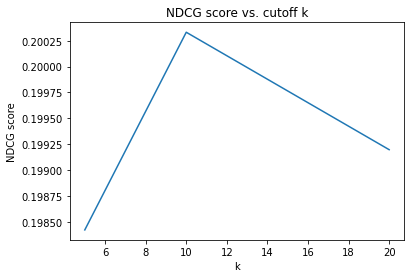

In [10]:
'''Using Ndcg as metric for evaluation'''

def ndcg_at_k(relevances, k):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at k.
    relevances: list of document relevances (0 or 1) in the ranked order
    k: the cutoff for the ranking position
    """
    dcg = np.sum((np.power(2, relevances[:k]) - 1) / np.log2(np.arange(2, k + 2)))
    idcg = np.sum((np.power(2, sorted(relevances, reverse=True)[:k]) - 1) / np.log2(np.arange(2, k + 2)))
    return dcg / idcg

k_values = [5, 10, 20]
ndcg_scores = []
for k in k_values:
    ndcg = ndcg_at_k(result_df['relevance_score'].tolist(), k)
    ndcg_scores.append(ndcg)
    print(f"NDCG score at {k}: {ndcg:.4f}")

# Plot the NDCG scores
import matplotlib.pyplot as plt
plt.plot(k_values, ndcg_scores)
plt.xlabel('k')
plt.ylabel('NDCG score')
plt.title('NDCG score vs. cutoff k')
plt.show()

# the reason it was 1 is because in this dataframe all the documenz as fixed position so when sorted the one with most similariy was lawys in the top

--------------------------------------------------------------------------


In [8]:
X = result_df[['title', 'abstract']]
y = result_df['relevance_score']


In [9]:
# Convert the sparse matrices to dense numpy arrays
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

NameError: name 'X_train' is not defined

In [ ]:
# Split dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(document_vectors, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Train the LambdaMART model
from sklearn.model_selection import train_test_split
from pyltr.models.lambdamart import LambdaMART
from sklearn.metrics import ndcg_score


# Train the LambdaMART model
model = LambdaMART()
model.fit(X_train, y_train, X_val, y_val)

# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
ndcg = ndcg_score(np.array([y_test]), np.array([y_pred]), k=10)
print('NDCG@10:', ndcg)

In [ ]:
import rankpy 
from rankpy.models import LambdaMART
